Following https://github.com/DataTalksClub/machine-learning-zoomcamp/blob/master/08-deep-learning/pytorch/README.md

Note: This was run in google colab for GPU access.

In [6]:
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 54.15 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [7]:
import torch

array([[[179, 181, 176],
        [179, 181, 176],
        [179, 181, 176],
        ...,
        [237, 230, 222],
        [238, 231, 223],
        [236, 229, 221]],

       [[180, 181, 176],
        [177, 178, 173],
        [177, 178, 173],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [235, 228, 220]],

       [[178, 179, 174],
        [175, 176, 171],
        [175, 176, 171],
        ...,
        [237, 230, 222],
        [237, 230, 222],
        [234, 227, 219]],

       ...,

       [[155, 149, 137],
        [155, 149, 137],
        [158, 152, 140],
        ...,
        [157, 149, 138],
        [159, 151, 140],
        [156, 148, 137]],

       [[151, 145, 133],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [155, 147, 136],
        [157, 149, 138],
        [155, 147, 136]],

       [[150, 144, 132],
        [152, 146, 134],
        [157, 151, 139],
        ...,
        [154, 146, 135],
        [155, 147, 136],
        [153, 145, 134]]], dtype=uint8)
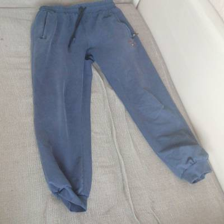

In [8]:
from PIL import Image
import numpy as np

img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
X = np.array(img.resize((224, 224)))
X

## Pre-trained models

Instead of training from scratch, we'll use a model pre-trained on ImageNet (1.4M images, 1000 classes).



In [9]:
import torchvision.models as models
from torchvision import transforms

In [10]:
model = models.mobilenet_v2(weights='IMAGENET1K_V1')
model.eval()

# Preprocessing for MobileNetV2
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
img = Image.open('clothing-dataset-small/train/pants/0098b991-e36e-4ef1-b5ee-4154b21e2a92.jpg')
img_t = preprocess(img)
batch_t = torch.unsqueeze(img_t, 0)

# Make prediction
with torch.no_grad():
    output = model(batch_t)

# Get top predictions
_, indices = torch.sort(output, descending=True)

In [12]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt -O imagenet_classes.txt

# Load ImageNet class names
with open("imagenet_classes.txt", "r") as f:
    categories = [s.strip() for s in f.readlines()]

# Get top 5 predictions
top5_indices = indices[0, :5].tolist()
top5_classes = [categories[i] for i in top5_indices]

print("Top 5 predictions:")
for i, class_name in enumerate(top5_classes):
    print(f"{i+1}: {class_name}")

--2025-12-03 09:11:51--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0.001s  

2025-12-03 09:11:51 (15.6 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]

Top 5 predictions:
1: jean
2: suit
3: cardigan
4: sweatshirt
5: overskirt


## Transfer Learning

Reusing a model trained on ImageNet for the task of clothing classification (our dataset).

Approach:
1. Load pre-trained model
2. Remove original classification head
3. Freeze convolutional layers
4. Add custom layers for our task
5. Train only the new layers

In [20]:
import os
from torch.utils.data import Dataset

#image data generator
class ClothingDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [21]:
# preprocessing

from torchvision import transforms

input_size = 224

# ImageNet normalization values
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_transforms = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [22]:
# create dataloaders

from torch.utils.data import DataLoader

train_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/train',
    transform=train_transforms
)

val_dataset = ClothingDataset(
    data_dir='./clothing-dataset-small/validation',
    transform=val_transforms
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [15]:
# building the model

import torch.nn as nn
import torchvision.models as models

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.output_layer = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.output_layer(x)
        return x

In [23]:
# prep for training

import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("running on:", device)

model = ClothingClassifierMobileNet(num_classes=10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

running on: cuda


### Training
THIS CODE IS FOR EXPLANATORY PURPOSES. The same code, without comments, is in the next cell inside a function

```
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients to prevent accumulation
        #zero-ing gradients is very important, otherwise your model will use incorrect gradients for the next batch.
        optimizer.zero_grad()
        # Forward pass
        outputs = model(inputs)
        # Calculate the loss
        loss = criterion(outputs, labels)
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate training loss
        running_loss += loss.item()
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    # Print epoch results
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
```

### Put all the above code into a callable function and remove comments:

In [24]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

In [21]:
num_epochs = 10
train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/10
  Train Loss: 0.7240, Train Acc: 0.7692
  Val Loss: 0.8037, Val Acc: 0.7449
Epoch 2/10
  Train Loss: 0.7340, Train Acc: 0.7793
  Val Loss: 0.9714, Val Acc: 0.7302
Epoch 3/10
  Train Loss: 0.6193, Train Acc: 0.8103
  Val Loss: 1.2903, Val Acc: 0.6716
Epoch 4/10
  Train Loss: 0.5454, Train Acc: 0.8413
  Val Loss: 0.7876, Val Acc: 0.8006
Epoch 5/10
  Train Loss: 0.4710, Train Acc: 0.8475
  Val Loss: 0.9319, Val Acc: 0.7449
Epoch 6/10
  Train Loss: 0.4976, Train Acc: 0.8445
  Val Loss: 1.1098, Val Acc: 0.7361
Epoch 7/10
  Train Loss: 0.5269, Train Acc: 0.8449
  Val Loss: 1.2946, Val Acc: 0.7009
Epoch 8/10
  Train Loss: 0.4376, Train Acc: 0.8664
  Val Loss: 1.1415, Val Acc: 0.7243
Epoch 9/10
  Train Loss: 0.5582, Train Acc: 0.8468
  Val Loss: 1.2574, Val Acc: 0.7390
Epoch 10/10
  Train Loss: 0.5394, Train Acc: 0.8468
  Val Loss: 1.3355, Val Acc: 0.7243


In [25]:
#tuning learning rate
# try multiple lr values and train for a few epochs. compare performance

def make_model(learning_rate=0.01):
    model = ClothingClassifierMobileNet(num_classes=10)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer


In [23]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

for lr in learning_rates:
    print(f'\n=== Learning Rate: {lr} ===')
    model, optimizer = make_model(learning_rate=lr)
    train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)


=== Learning Rate: 0.0001 ===
Epoch 1/10
  Train Loss: 2.0139, Train Acc: 0.2982
  Val Loss: 1.8201, Val Acc: 0.3988
Epoch 2/10
  Train Loss: 1.6484, Train Acc: 0.4919
  Val Loss: 1.5313, Val Acc: 0.5367
Epoch 3/10
  Train Loss: 1.4133, Train Acc: 0.5825
  Val Loss: 1.3313, Val Acc: 0.6041
Epoch 4/10
  Train Loss: 1.2476, Train Acc: 0.6463
  Val Loss: 1.1986, Val Acc: 0.6422
Epoch 5/10
  Train Loss: 1.1292, Train Acc: 0.6861
  Val Loss: 1.1055, Val Acc: 0.6862
Epoch 6/10
  Train Loss: 1.0414, Train Acc: 0.7122
  Val Loss: 1.0120, Val Acc: 0.6921
Epoch 7/10
  Train Loss: 0.9717, Train Acc: 0.7370
  Val Loss: 0.9606, Val Acc: 0.7214
Epoch 8/10
  Train Loss: 0.9105, Train Acc: 0.7490
  Val Loss: 0.9136, Val Acc: 0.7273
Epoch 9/10
  Train Loss: 0.8659, Train Acc: 0.7634
  Val Loss: 0.8711, Val Acc: 0.7390
Epoch 10/10
  Train Loss: 0.8250, Train Acc: 0.7738
  Val Loss: 0.8341, Val Acc: 0.7331

=== Learning Rate: 0.001 ===
Epoch 1/10
  Train Loss: 1.3565, Train Acc: 0.5779
  Val Loss: 0.879

In [24]:
leaning_rate = 0.01

## Checkpointing

We want to save the best model from the training loop (before overfitting).

This is done by checkpointing the model.

In [26]:
def train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device):
    best_val_accuracy = 0.0  # Initialize variable to track the best validation accuracy


    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_val_accuracy:
            best_val_accuracy = val_acc
            checkpoint_path = f'clothing_v4_{epoch+1:02d}_{val_acc:.3f}.pth'
            torch.save(model.state_dict(), checkpoint_path)
            print(f'Checkpoint saved: {checkpoint_path}')

## Adding more inner layers

So now we have optimised the learning rate.

We want to see if adding another inner custom layer will improve model performance.

In [28]:
class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        for param in self.base_model.parameters():
            param.requires_grad = False

        self.base_model.classifier = nn.Identity()

        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))
        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.output_layer(x)
        return x

    def make_model(learning_rate=0.001, size_inner=100):
      model = ClothingClassifierMobileNet(
          num_classes=10,
          size_inner=size_inner
      )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 26)

Experiment with different sizes:

- Try: size_inner = [10, 100, 1000]
- Larger layers: more capacity, may overfit
- Smaller layers: faster, may underfit

Key points:

- Inner layer uses ReLU activation
- Output layer has no activation (logits)
- CrossEntropyLoss applies softmax internally

In [32]:
#trying different inner sizes

for size_inner in [10, 100, 1000]:
  print("size_inner = ", size_inner)

  model, optimizer = make_model(
      learning_rate=0.001,
      size_inner=size_inner
  )
  num_epochs=10
  train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

size_inner =  10
Epoch 1/10
  Train Loss: 1.7362, Train Acc: 0.3983
  Val Loss: 1.4072, Val Acc: 0.4985
Checkpoint saved: clothing_v4_01_0.499.pth
Epoch 2/10
  Train Loss: 1.3677, Train Acc: 0.5280
  Val Loss: 1.1663, Val Acc: 0.5982
Checkpoint saved: clothing_v4_02_0.598.pth
Epoch 3/10
  Train Loss: 1.2149, Train Acc: 0.5808
  Val Loss: 1.0384, Val Acc: 0.6774
Checkpoint saved: clothing_v4_03_0.677.pth
Epoch 4/10
  Train Loss: 1.1062, Train Acc: 0.6203
  Val Loss: 0.9321, Val Acc: 0.6745
Epoch 5/10
  Train Loss: 1.0577, Train Acc: 0.6408
  Val Loss: 0.8983, Val Acc: 0.6891
Checkpoint saved: clothing_v4_05_0.689.pth
Epoch 6/10
  Train Loss: 1.0073, Train Acc: 0.6516
  Val Loss: 0.8616, Val Acc: 0.7361
Checkpoint saved: clothing_v4_06_0.736.pth
Epoch 7/10
  Train Loss: 0.9832, Train Acc: 0.6574
  Val Loss: 0.8086, Val Acc: 0.7243
Epoch 8/10
  Train Loss: 0.9327, Train Acc: 0.6679
  Val Loss: 0.7897, Val Acc: 0.7537
Checkpoint saved: clothing_v4_08_0.754.pth
Epoch 9/10
  Train Loss: 0.88

## Dropout regularization

Randomly drop neurons to prevent overfitting (e.g, a specific logo --> t-shirt)

How it works:

- Training: randomly set fraction of activations to 0
- Inference: use all neurons (dropout disabled automatically)
- Creates ensemble effect

Benefits:

- Prevents relying on specific features
- Forces learning robust patterns
- Reduces overfitting


In [29]:
import torch.nn as nn

class ClothingClassifierMobileNet(nn.Module):
    def __init__(self, size_inner=100, droprate=0.2, num_classes=10):
        super(ClothingClassifierMobileNet, self).__init__()

        # Load pre-trained MobileNetV2
        self.base_model = models.mobilenet_v2(weights='IMAGENET1K_V1')

        # Freeze base model parameters
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Remove original classifier
        self.base_model.classifier = nn.Identity()

        # Add custom layers
        self.global_avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        self.inner = nn.Linear(1280, size_inner)  # New inner layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(droprate)  # Add dropout layer
        self.output_layer = nn.Linear(size_inner, num_classes)

    def forward(self, x):
        x = self.base_model.features(x)
        x = self.global_avg_pooling(x)
        x = torch.flatten(x, 1)
        x = self.inner(x)
        x = self.relu(x)
        x = self.dropout(x)  # Apply dropout
        x = self.output_layer(x)
        return x


def make_model(
        learning_rate=0.01,
        size_inner=100,
        droprate=0.2,
):
    model = ClothingClassifierMobileNet(
        num_classes=10,
        size_inner=size_inner,
        droprate=droprate,
    )
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, optimizer

In [30]:
num_epochs = 50
learning_rate = 0.001
size_inner = 100

model, optimizer = make_model(
    learning_rate=0.001,
    size_inner=100,
    droprate=0.2,
)

train_and_evaluate(model, optimizer, train_loader, val_loader, criterion, num_epochs, device)

Epoch 1/50
  Train Loss: 1.4518, Train Acc: 0.5293
  Val Loss: 0.8753, Val Acc: 0.7097
Checkpoint saved: clothing_v4_01_0.710.pth
Epoch 2/50
  Train Loss: 0.8699, Train Acc: 0.7151
  Val Loss: 0.6882, Val Acc: 0.7801
Checkpoint saved: clothing_v4_02_0.780.pth
Epoch 3/50
  Train Loss: 0.7031, Train Acc: 0.7669
  Val Loss: 0.6125, Val Acc: 0.7889
Checkpoint saved: clothing_v4_03_0.789.pth
Epoch 4/50
  Train Loss: 0.6253, Train Acc: 0.7914
  Val Loss: 0.5933, Val Acc: 0.7977
Checkpoint saved: clothing_v4_04_0.798.pth
Epoch 5/50
  Train Loss: 0.5789, Train Acc: 0.8106
  Val Loss: 0.5431, Val Acc: 0.8123
Checkpoint saved: clothing_v4_05_0.812.pth
Epoch 6/50
  Train Loss: 0.5212, Train Acc: 0.8204
  Val Loss: 0.5498, Val Acc: 0.8152
Checkpoint saved: clothing_v4_06_0.815.pth
Epoch 7/50
  Train Loss: 0.5035, Train Acc: 0.8286
  Val Loss: 0.5326, Val Acc: 0.8006
Epoch 8/50
  Train Loss: 0.4583, Train Acc: 0.8504
  Val Loss: 0.5624, Val Acc: 0.8006
Epoch 9/50
  Train Loss: 0.4550, Train Acc: 0.

Can also experiment with different dropout rates (same as for method of trying different learning rate or inner layer size).

The larger the droprate, the longer you have to train the model for.

Experimentation:

- Try: droprate = [0.0, 0.2, 0.5, 0.8]
- Typical values: 0.2 to 0.5
- Higher dropout may need more training epochs
- (Our case: best droprate is 0.2)

## Data Augmentation

Artificially increase dataset size by augmenting existing images.
- Rotating
- Zooming
- Shearing

! NEVER augment validation/test data

In [1]:
# Training transforms WITH augmentation
train_transforms = transforms.Compose([
    transforms.RandomRotation(10),           # Rotate up to 10 degrees
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),       # Horizontal flip
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms - NO augmentation, same as before
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

NameError: name 'transforms' is not defined

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))